In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as misc
%matplotlib inline

import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

/Users/abhishek/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# Function to get class designations from yes/no data
def class_designation(mat):
    yesses = mat[:,1]
    if np.sum(yesses)==0:
        # If expert said no to all questions, pick a designation randomly. 
        return np.random.choice(4)
    else:
        # Otherwise pick randomly from among all the questions they said yes to. 
        return np.random.choice(np.arange(0,4,1)[yesses>0])

## EM with Single Confusion Matrix

In [5]:
def E_step(rho, theta, r):
    num_data = r.shape[0]
    num_classes = theta.shape[0]
    num_experts = r.shape[1]
    
    zeds = np.zeros((num_data, num_classes))
    
    for i in range(num_data):
        for k in range(num_classes):
            log_numerator = np.log(rho[k]) + np.sum([[np.sum(r[i,j]==t)*np.log(theta[k,t]) \
                                                      for j in range(num_experts)] for t in range(num_classes)])
            log_denominator = misc.logsumexp([np.log(rho[k_p]) + np.sum([[np.sum(r[i,j]==t)*np.log(theta[k_p,t]) \
                                                for j in range(num_experts)] for t in range(num_classes)]) \
                                              for k_p in range(num_classes)])
            zeds[i,k] = np.exp(log_numerator - log_denominator)
    return zeds

In [6]:
def M_step(z,r):
    num_classes = z.shape[1]
    num_data = z.shape[0]
    num_experts = r.shape[1]
    
    thet = np.zeros((num_classes,num_classes))
    for k in range(num_classes):
        for t in range(num_classes):
            numerator=0
            denominator=0
            for i in range(num_data):
                for j in range(num_classes):
                    numerator += np.sum(z[i,k][r[i,j]==t])
                    denominator += np.sum([np.sum(z[i,k][r[i,j]==t_p]) for t_p in range(num_classes)])
  
            thet[k,t] = numerator/denominator
    
    rh = np.zeros(num_classes)
    for k in range(num_classes):
        rh[k] = np.sum(z[:,k])/np.sum(z)
            
    return thet, rh

In [7]:
# A function to run it:

def results_shared_conf(data_file, true_class_file):
    data = np.load(data_file)
    trueCls = np.load(true_class_file)
    
    # Reconfigure data to resemble that used in Liu and Wang
    if len(data.shape)==3:
        # Multinomial data
        r = np.argmax(data,axis=2)
    elif len(data.shape)==4:
        # Yes/no data
        r = np.zeros((data.shape[0], data.shape[1]))
        for n in range(data.shape[0]):
            for exp in range(data.shape[1]):
                # Use class_designation function to make a class designation for this data point.  
                r[n,exp] = class_designation(data[n,exp])

    # Number of data points
    num_data     = data.shape[0]
    # Number of experts performing classification
    num_experts  = data.shape[1]
    # Number of classes
    num_classes  = data.shape[2]

    # Initialize rho, the proportion of each class, to be even.  
    rho = np.repeat(1./num_classes, num_classes)

    # Initialize the shared confusion matrix with a bias lambda
    lambdaa = 5.
    theta = np.ones((num_classes,num_classes))*(1./(lambdaa+num_classes))
    np.fill_diagonal(theta, np.repeat((lambdaa/(lambdaa+num_classes)),num_classes))

    # Nonsense initial values to test convergence
    z_old = 500
    z = 100
    ctr = 0

    while np.sum(z_old - z) > .00001:
        z_old = z
        z = E_step(rho, theta, r)
        theta, rho = M_step(z, r)
        ctr+=1

    accuracy = 100.*np.sum(np.argmax(z,axis=1)==trueCls)/num_data
    
    print "---------------------------------------------------------------"
    print "Shared Confusion Matrix"
    print "{} data points".format(num_data)
    print "Converged within {} iterations".format(ctr)
    print "Theta:"
    print theta
    print "Rho:", rho
    print "Accuracy is {}%".format(accuracy)
    print
    
    return accuracy
    

## EM, multiple confusion matrices

In [8]:
def E_step2(rho, r, thetas):
    num_data = r.shape[0]
    num_classes = thetas.shape[1]
    num_experts = r.shape[1]    
    
    zeds = np.zeros((num_data, num_classes))
    
    for i in range(num_data):
        for k in range(num_classes):
            log_numerator = np.log(rho[k]) + np.sum([thetas[j,k,r[i,j]] for j in range(num_experts)])
            log_denominator = misc.logsumexp([np.log(rho[k_p]) + np.sum([thetas[j,k_p,r[i,j]]\
                                                                       for j in range(num_experts)]) \
                                                                          for k_p in range(num_classes)])
            zeds[i,k] = np.exp(log_numerator - log_denominator)
            
    return zeds

In [9]:
def M_step2(z, r):
    num_classes = z.shape[1]
    num_data = z.shape[0]
    num_experts = r.shape[1]
    
    thet = np.zeros((num_experts,num_classes,num_classes))
    for k in range(num_classes):
        for t in range(num_classes):
            for j in range(num_experts):
                numerator=0
                denominator=0
                for i in range(num_data):
                    numerator += np.sum(z[i,k][r[i,j]==t])
                    denominator += np.sum([np.sum(z[i,k][r[i,j]==t_p]) for t_p in range(num_classes)])
                thet[j,k,t] = numerator/denominator
    
    rh = np.zeros(num_classes)
    for k in range(num_classes):
        rh[k] = np.sum(z[:,k])/np.sum(z)
            
    return thet, rh
                    

In [10]:
# Now run it:

def results_separate_conf(data_file, true_class_file):
    # Load Data
    data = np.load(data_file)
    trueCls = np.load(true_class_file)   
    
    # Reconfigure data to resemble that used in Liu and Wang
    if len(data.shape)==3:
        # Multinomial data
        r = np.argmax(data,axis=2)
    elif len(data.shape)==4:
        # Yes/no data
        r = np.zeros((data.shape[0], data.shape[1]))
        for n in range(data.shape[0]):
            for exp in range(data.shape[1]):
                # Use class_designation function to make a class designation for this data point.  
                r[n,exp] = class_designation(data[n,exp])

    # Number of data points
    num_data     = data.shape[0]
    # Number of experts performing classification
    num_experts  = data.shape[1]
    # Number of classes
    num_classes  = data.shape[2]

    # Initialize rho, the proportion of each class, to be even.  
    rho = np.repeat(1./num_classes, num_classes)

    # Initialize the shared confusion matrix with a bias lambda
    lambdaa = 5.
    theta = np.ones((num_classes,num_classes))*(1./(lambdaa+num_classes))
    np.fill_diagonal(theta, np.repeat((lambdaa/(lambdaa+num_classes)),num_classes))
    
    # All the confusion matrices start out the same
    thetas = np.stack([theta]*num_experts)

    # Nonsense initial values to test convergence
    z_old = 500
    z = 100
    ctr = 0

    while np.sum(z_old - z) > .00001:
        z_old = z
        z = E_step2(rho, r, thetas)
        thetas, rho = M_step2(z, r)
        ctr+=1
        
    accuracy = 100.*np.sum(np.argmax(z,axis=1)==trueCls)/num_data
    
    print "---------------------------------------------------------------"
    print "Separate Confusion Matrices"
    print "{} data points".format(num_data)
    print "Converged within {} iterations".format(ctr)
    print "Theta:"
    print thetas
    print "Rho:", rho
    print "Accuracy is {}%".format(accuracy)
    print
    
    return accuracy

## Multiclass--Easy

In [11]:
ran = ['40','80','100','200','500']
results_shared=np.zeros(len(ran))
results_separate=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/same_preset_MC_'+num+'_5_4.npz.npy'
    trueCls = '../data/same_preset_MC_'+num+'_5_4_reference_classes.npy'
    results_shared[ii] = results_shared_conf(data, trueCls)
    results_separate[ii] = results_separate_conf(data, trueCls)


---------------------------------------------------------------
Shared Confusion Matrix
40 data points
Converged within 2 iterations
Theta:
[[  9.49623743e-01   2.50809754e-02   3.27412376e-04   2.49678689e-02]
 [  2.41758643e-02   9.20785423e-01   4.48207338e-02   1.02179790e-02]
 [  9.34764688e-02   3.08552197e-02   8.16721486e-01   5.89468259e-02]
 [  8.48178499e-02   6.17750843e-02   7.00801846e-02   7.83326881e-01]]
Rho: [ 0.25009184  0.26085865  0.25641973  0.23262978]
Accuracy is 95.0%

---------------------------------------------------------------
Separate Confusion Matrices
40 data points
Converged within 2 iterations
Theta:
[[[ 0.71592972  0.07722236  0.0981307   0.10871721]
  [ 0.07528594  0.73418469  0.06786897  0.12266041]
  [ 0.09885986  0.10752876  0.67221556  0.12139582]
  [ 0.10068568  0.11867694  0.11099314  0.66964424]]

 [[ 0.65145628  0.06731064  0.13746996  0.14376312]
  [ 0.06979614  0.70222429  0.13006856  0.09791101]
  [ 0.06527867  0.07030674  0.76965163  0.0

## Multiclass--hard

In [12]:
ran = ['40','80','100','200','500']
results_extrahard_shared=np.zeros(len(ran))
results_extrahard_separate=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/extrahard_MC_'+num+'_5_4.npz.npy'
    trueCls = '../data/extrahard_MC_'+num+'_5_4_reference_classes.npy'
    results_extrahard_shared[ii] = results_shared_conf(data, trueCls)
    results_extrahard_separate[ii] = results_separate_conf(data, trueCls)


---------------------------------------------------------------
Shared Confusion Matrix
40 data points
Converged within 2 iterations
Theta:
[[ 0.67841758  0.06463535  0.07754329  0.17940378]
 [ 0.16663975  0.6130368   0.15656751  0.06375594]
 [ 0.0314023   0.07782152  0.68963642  0.20113975]
 [ 0.10250931  0.11875205  0.19862498  0.58011366]]
Rho: [ 0.24985445  0.25153834  0.26416265  0.23444456]
Accuracy is 90.0%

---------------------------------------------------------------
Separate Confusion Matrices
40 data points
Converged within 2 iterations
Theta:
[[[ 0.38169501  0.22055959  0.18139226  0.21635315]
  [ 0.1464923   0.48327289  0.19761414  0.17262068]
  [ 0.11435532  0.18918553  0.46242333  0.23403583]
  [ 0.15957372  0.2341612   0.23077649  0.37548859]]

 [[ 0.41238617  0.15513643  0.28770163  0.14477577]
  [ 0.23576236  0.35547535  0.24155758  0.16720471]
  [ 0.20177271  0.14985028  0.47355202  0.17482499]
  [ 0.25293998  0.15803331  0.37523197  0.21379474]]

 [[ 0.28457894  0

## Yes/No--Easy

In [13]:
ran = ['40','80','100','200','500']
results_yn_easy_shared=np.zeros(len(ran))
results_yn_easy_separate=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/same_preset_YN_'+num+'_5_4.npz.npy'
    trueCls = '../data/same_preset_MC_'+num+'_5_4_reference_classes.npy'
    results_yn_easy_shared[ii] = results_shared_conf(data, trueCls)
    results_yn_easy_separate[ii] = results_separate_conf(data, trueCls)


---------------------------------------------------------------
Shared Confusion Matrix
40 data points
Converged within 2 iterations
Theta:
[[  9.24521788e-01   7.50495183e-02   7.84436365e-08   4.28615466e-04]
 [  1.05285758e-04   8.60819635e-01   7.42199853e-02   6.48550936e-02]
 [  2.49004765e-02   7.89012166e-02   8.96198230e-01   7.68796962e-08]
 [  9.99811323e-02   2.63459917e-01   5.43781180e-06   6.36553513e-01]]
Rho: [ 0.25016492  0.24911712  0.2513497   0.24936826]
Accuracy is 97.5%

---------------------------------------------------------------
Separate Confusion Matrices
40 data points
Converged within 2 iterations
Theta:
[[[ 0.61260717  0.17957198  0.10866739  0.09915346]
  [ 0.24104076  0.44526807  0.17581602  0.13787515]
  [ 0.11864694  0.08165279  0.7153717   0.08432858]
  [ 0.13278806  0.10534775  0.15934489  0.60251929]]

 [[ 0.59181458  0.26482524  0.07568285  0.06767732]
  [ 0.15725507  0.61465151  0.14009523  0.08799819]
  [ 0.16431118  0.19793589  0.57269118  0.0

/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Yes/No--Hard

In [14]:
ran = ['40','80','100','200','500']
results_yn_extrahard_shared=np.zeros(len(ran))
results_yn_extrahard_separate=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/extrahard_YN_'+num+'_5_4.npz.npy'
    trueCls = '../data/extrahard_MC_'+num+'_5_4_reference_classes.npy'
    results_yn_extrahard_shared[ii] = results_shared_conf(data, trueCls)
    results_yn_extrahard_separate[ii] = results_separate_conf(data, trueCls)


---------------------------------------------------------------
Shared Confusion Matrix
40 data points
Converged within 2 iterations
Theta:
[[ 0.58914331  0.14804779  0.12996049  0.13284841]
 [ 0.16607723  0.5817375   0.12847996  0.12370531]
 [ 0.05816894  0.09002655  0.72792596  0.12387855]
 [ 0.15512967  0.11244539  0.06778412  0.66464081]]
Rho: [ 0.23257355  0.25937919  0.22080416  0.28724311]
Accuracy is 85.0%

---------------------------------------------------------------
Separate Confusion Matrices
40 data points
Converged within 2 iterations
Theta:
[[[ 0.3476859   0.25467542  0.19704493  0.20059376]
  [ 0.15129747  0.43661143  0.19867585  0.21341525]
  [ 0.17804017  0.25639662  0.35365357  0.21190964]
  [ 0.14264077  0.26142784  0.16507458  0.43085682]]

 [[ 0.27714925  0.30774431  0.18323883  0.23186761]
  [ 0.16453743  0.37965987  0.16183286  0.29396983]
  [ 0.1572678   0.28734829  0.28185782  0.27352609]
  [ 0.11899202  0.24114816  0.17801237  0.46184745]]

 [[ 0.35656722  0

/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(80, 100)

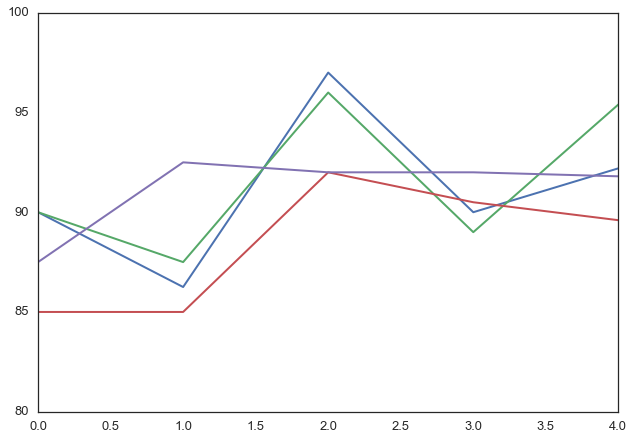

In [15]:
plt.plot(results_extrahard_shared, lw=2)
plt.plot(results_extrahard_separate, lw=2)
plt.plot(results_yn_extrahard_shared, lw=2)
plt.plot(results_yn_extrahard_separate, lw=2)
plt.ylim(80,100)


(94, 101)

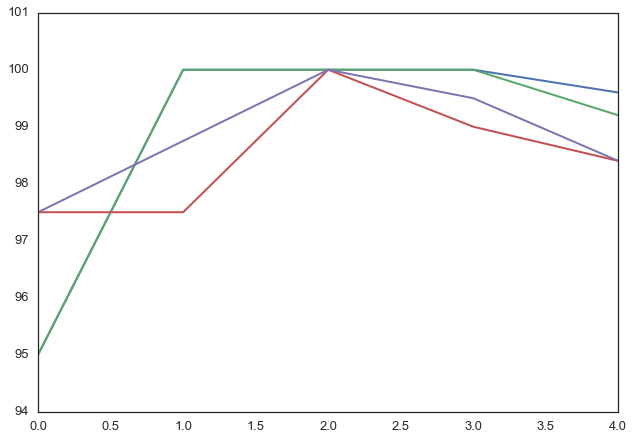

In [16]:
plt.plot(results_shared, lw=2)
plt.plot(results_separate, lw=2)
plt.plot(results_yn_easy_shared, lw=2)
plt.plot(results_yn_easy_separate, lw=2)
plt.ylim(94,101)

(87, 101)

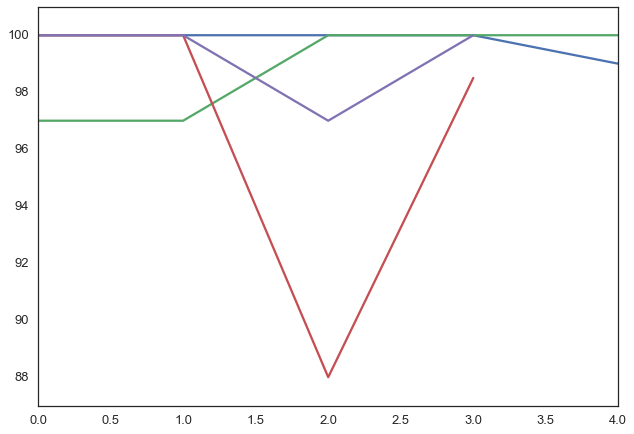

In [17]:
# Easy Data
plt.plot([100,100,100,100,99], label = "Yes/No: Simulated Annealing")
plt.plot([97,97,100,100,100], label = "Multiclass: Simulated Annealing")
plt.plot([100,100,88,98.5], label = "Multiclass: PyMC")
plt.plot([100,100,97,100], label = "Yes/No: PyMC")
plt.ylim((87,101))

In [ ]:
SA-YN-SP[ 100, 100, 100, 100, 99]
SA-YN-EH[97, 92, 99, 96, 96]
SA-MC-SP [97, 97, 100, 100, 100]
SA-MC-EH[87, 85, 95, 88, 93]
PyMC-MC[100, 100 ,88, 98.5, -]
PyMC-YN [100, 100 ,97, 100, - ]

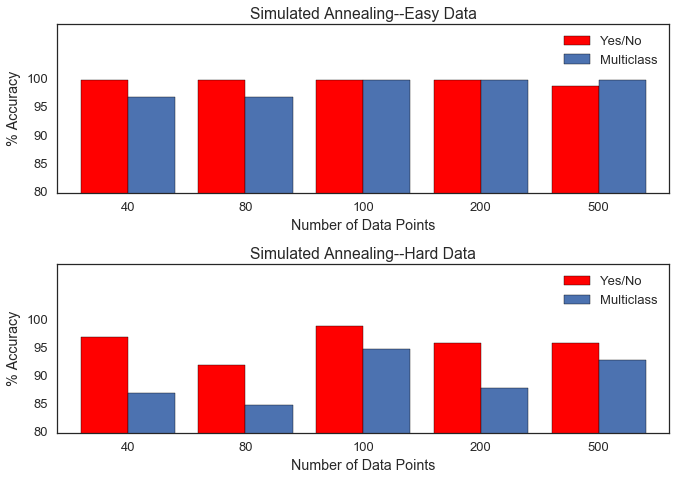

In [31]:
plt.subplot(2,1,1)
plt.tight_layout(5,5,5)
plt.bar(range(5),[100,100,100,100,99],0.4,color='red', label="Yes/No")
plt.bar(np.arange(0,5,1)+0.4, [97,97,100,100,100],0.4, label="Multiclass")
plt.xlim(-0.2,5)
plt.ylim(80,110)
plt.ylabel("% Accuracy")
plt.yticks(np.arange(80,101,5))
plt.xticks(np.arange(0,5,1)+0.4, [40,80,100,200,500])
plt.xlabel("Number of Data Points")
plt.legend(loc='best')
plt.title("Simulated Annealing--Easy Data")

plt.subplot(2,1,2)
plt.bar(range(5),[97,92,99,96,96],0.4,color='red', label="Yes/No")
plt.bar(np.arange(0,5,1)+0.4, [87, 85, 95, 88, 93],0.4, label= "Multiclass")
plt.xlim(-0.2,5)
plt.ylim(80,110)
plt.ylabel("% Accuracy")
plt.yticks(np.arange(80,101,5))
plt.xticks(np.arange(0,5,1)+0.4, [40,80,100,200,500])
plt.xlabel("Number of Data Points")
plt.legend(loc='best')
plt.title("Simulated Annealing--Hard Data")
plt.savefig('../output/sa.png')

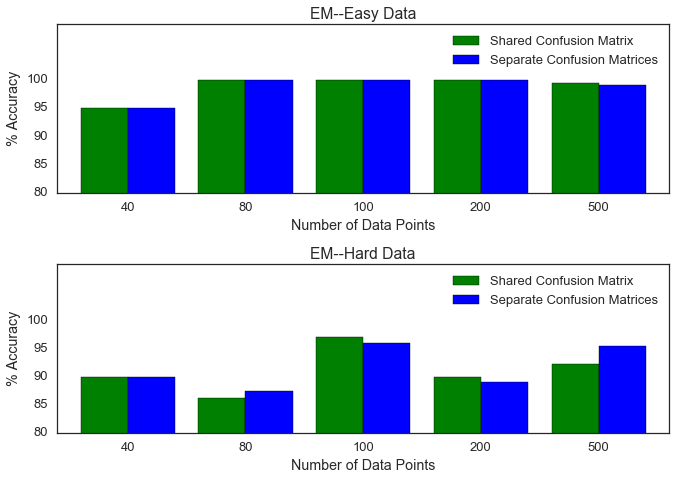

In [32]:
plt.subplot(2,1,1)
plt.tight_layout(5,5,5)
plt.bar(range(5),results_shared,0.4,color='green', label="Shared Confusion Matrix")
plt.bar(np.arange(0,5,1)+0.4, results_separate,0.4, label="Separate Confusion Matrices", color='blue')
plt.xlim(-0.2,5)
plt.ylim(80,110)
plt.ylabel("% Accuracy")
plt.yticks(np.arange(80,101,5))
plt.xticks(np.arange(0,5,1)+0.4, [40,80,100,200,500])
plt.xlabel("Number of Data Points")
plt.legend(loc='best')
plt.title("EM--Easy Data")

plt.subplot(2,1,2)
plt.bar(range(5),results_extrahard_shared,0.4,color='green', label="Shared Confusion Matrix")
plt.bar(np.arange(0,5,1)+0.4, results_extrahard_separate,0.4, label= "Separate Confusion Matrices",color='blue')
plt.xlim(-0.2,5)
plt.ylim(80,110)
plt.ylabel("% Accuracy")
plt.yticks(np.arange(80,101,5))
plt.xticks(np.arange(0,5,1)+0.4, [40,80,100,200,500])
plt.xlabel("Number of Data Points")
plt.legend(loc='best')
plt.title("EM--Hard Data")
plt.savefig('../output/em.png')

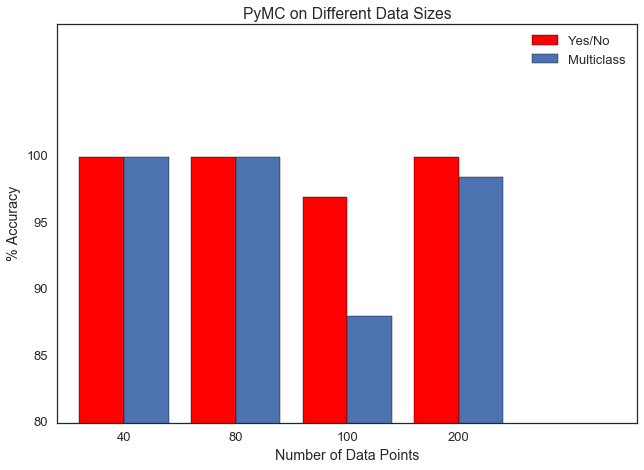

In [24]:
plt.bar(range(4),[100,100,97,100],0.4,color='red', label="Yes/No")
plt.bar(np.arange(0,4,1)+0.4, [100,100,88,98.5],0.4, label="Multiclass")
plt.xlim(-0.2,5)
plt.ylim(80,110)
plt.ylabel("% Accuracy")
plt.yticks(np.arange(80,101,5))
plt.xticks(np.arange(0,4,1)+0.4, [40,80,100,200])
plt.xlabel("Number of Data Points")
plt.legend(loc='best')
plt.title("PyMC on Different Data Sizes")
plt.savefig('../output/pymc.png')